In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import random
import numpy as np
import timeit
from tqdm import tqdm

In [2]:
config = {
    'data_path': 'dataset/',
    'batch_size': 1024,
    'learning_rate': 2e-4,
    'channel': 1,
    'image_size': 64,
    'feature_map_size': 64, # Base number of feature maps
    'random_seed': 3,
    'device': 'cpu',
    'input_noise_dim': 100,
    'beta': 0.5,
    'num_epochs': 100,
}

In [3]:
# Set random seed for reproducibility
random.seed(config['random_seed'])
np.random.seed(config['random_seed'])
torch.manual_seed(config['random_seed'])
torch.cuda.manual_seed(config['random_seed'])
torch.cuda.manual_seed_all(config['random_seed'])
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_size, channel):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(channel, feature_map_size*2, 4, 2, 1, bias=False) # size [128, 32, 32]
        self.conv2 = nn.Conv2d(feature_map_size*2, feature_map_size*4, 4, 2, 1, bias=False) # size [256, 16, 16]
        self.conv3 = nn.Conv2d(feature_map_size*4, feature_map_size*8, 4, 2, 1, bias=False) # size [512, 8, 8]
        self.conv4 = nn.Conv2d(feature_map_size*8, feature_map_size*16, 4, 2, 1, bias=False) # size [1024, 4, 4]
        self.conv5 = nn.Conv2d(feature_map_size*16, 1, 4, 1, 0, bias=False) # size [1, 1, 1]
        
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.batch_norm1 = nn.BatchNorm2d(feature_map_size*4)
        self.batch_norm2 = nn.BatchNorm2d(feature_map_size*8)
        self.batch_norm3 = nn.BatchNorm2d(feature_map_size*16)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.batch_norm1(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        return x

In [5]:
discriminator = Discriminator(config['feature_map_size'], config['channel']).to(config['device'])
int = torch.randn(config['batch_size'], config['channel'], config['image_size'], config['image_size']).to(config['device'])
out = discriminator(int)
print(out.shape) # outpiut is a single value [batch_size, 1, 1, 1]


torch.Size([1024, 1, 1, 1])


In [6]:
class Generator(nn.Module):
    def __init__(self, input_vector_dim, feature_map_dim, channels):
        super(Generator, self).__init__()
        self.convt_1 = nn.ConvTranspose2d(input_vector_dim, feature_map_dim*16, 4, 1, 0, bias=False) #size [1024, 4, 4]
        self.convt_2 = nn.ConvTranspose2d(feature_map_dim*16, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.convt_3 = nn.ConvTranspose2d(feature_map_dim*8, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.convt_4 = nn.ConvTranspose2d(feature_map_dim*4, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.convt_5 = nn.ConvTranspose2d(feature_map_dim*2, channels, 4, 2, 1, bias=False) #size [3, 64, 64]
        
        self.relu = nn.ReLU()
        
        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)
        
        self.tanh = nn.Tanh()

    def forward(self, inp):
        x = self.convt_1(inp)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        
        x = self.convt_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        
        x = self.convt_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        
        x = self.convt_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)
        
        x = self.convt_5(x)
        out = self.tanh(x)
        
        return out

In [7]:
generator = Generator(config['input_noise_dim'], config['feature_map_size'], config['channel']).to(config['device'])
int = torch.randn(config['batch_size'], config['input_noise_dim'], 1, 1).to(config['device'])
out = generator(int)
print(out.shape) #output is image of size [batch_size, channel, 64, 64]

torch.Size([1024, 1, 64, 64])


In [8]:
dataset = ImageFolder(root=config['data_path'],
                        transform=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Resize(config['image_size']),
                            transforms.CenterCrop(config['image_size']),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))
                        ]))

dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

In [9]:
criterion = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=config['learning_rate'], betas=(config['beta'], 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=config['learning_rate'], betas=(config['beta'], 0.999))

100%|██████████| 3/3 [00:56<00:00, 18.97s/it]

Epoch [1/100], Discriminator Loss: 1.6691, Generator Loss: 8.8439


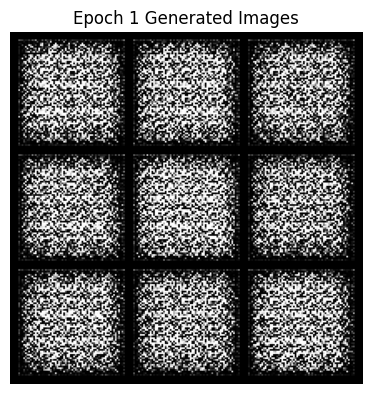

  2%|▏         | 2/100 [01:54<1:33:21, 57.15s/it]

Epoch [2/100], Discriminator Loss: 1.0382, Generator Loss: 10.3912


  3%|▎         | 3/100 [02:51<1:32:11, 57.03s/it]

Epoch [3/100], Discriminator Loss: 0.0668, Generator Loss: 9.0135


  4%|▍         | 4/100 [03:48<1:31:36, 57.26s/it]

Epoch [4/100], Discriminator Loss: 0.0320, Generator Loss: 8.5228


  5%|▌         | 5/100 [04:45<1:30:37, 57.24s/it]

Epoch [5/100], Discriminator Loss: 0.0169, Generator Loss: 8.6801


  6%|▌         | 6/100 [05:42<1:29:27, 57.10s/it]

Epoch [6/100], Discriminator Loss: 0.0112, Generator Loss: 8.3459


  7%|▋         | 7/100 [06:39<1:28:10, 56.89s/it]

Epoch [7/100], Discriminator Loss: 0.0090, Generator Loss: 8.0914


  8%|▊         | 8/100 [07:36<1:27:16, 56.92s/it]

Epoch [8/100], Discriminator Loss: 0.0070, Generator Loss: 7.4625


  9%|▉         | 9/100 [08:33<1:26:18, 56.91s/it]

Epoch [9/100], Discriminator Loss: 0.0072, Generator Loss: 8.1140


 10%|█         | 10/100 [09:29<1:25:15, 56.84s/it]

Epoch [10/100], Discriminator Loss: 0.0052, Generator Loss: 7.6859


 11%|█         | 11/100 [10:24<1:23:19, 56.18s/it]

Epoch [11/100], Discriminator Loss: 0.0058, Generator Loss: 8.0909


 12%|█▏        | 12/100 [11:16<1:20:40, 55.01s/it]

Epoch [12/100], Discriminator Loss: 0.0057, Generator Loss: 8.0595


 13%|█▎        | 13/100 [12:10<1:19:02, 54.51s/it]

Epoch [13/100], Discriminator Loss: 0.0053, Generator Loss: 7.9230


 14%|█▍        | 14/100 [13:05<1:18:41, 54.90s/it]

Epoch [14/100], Discriminator Loss: 0.0041, Generator Loss: 7.6258


 15%|█▌        | 15/100 [14:01<1:17:51, 54.96s/it]

Epoch [15/100], Discriminator Loss: 0.0042, Generator Loss: 7.6998


 16%|█▌        | 16/100 [14:55<1:16:55, 54.95s/it]

Epoch [16/100], Discriminator Loss: 0.0035, Generator Loss: 7.5666


 17%|█▋        | 17/100 [15:51<1:16:09, 55.06s/it]

Epoch [17/100], Discriminator Loss: 0.0034, Generator Loss: 7.5238


 18%|█▊        | 18/100 [16:46<1:15:27, 55.21s/it]

Epoch [18/100], Discriminator Loss: 0.0044, Generator Loss: 7.7770


 19%|█▉        | 19/100 [17:42<1:14:33, 55.22s/it]

Epoch [19/100], Discriminator Loss: 0.0052, Generator Loss: 7.7354


 20%|██        | 20/100 [18:37<1:13:38, 55.24s/it]

Epoch [20/100], Discriminator Loss: 0.0057, Generator Loss: 8.0573


 21%|██        | 21/100 [19:33<1:13:02, 55.47s/it]

Epoch [21/100], Discriminator Loss: 0.0084, Generator Loss: 8.4001


 22%|██▏       | 22/100 [20:39<1:16:10, 58.59s/it]

Epoch [22/100], Discriminator Loss: 0.0105, Generator Loss: 8.2484


 23%|██▎       | 23/100 [21:54<1:21:27, 63.47s/it]

Epoch [23/100], Discriminator Loss: 0.0160, Generator Loss: 8.0636


 24%|██▍       | 24/100 [23:09<1:25:05, 67.18s/it]

Epoch [24/100], Discriminator Loss: 0.0180, Generator Loss: 7.9342


 25%|██▌       | 25/100 [24:21<1:25:39, 68.53s/it]

Epoch [25/100], Discriminator Loss: 0.2157, Generator Loss: 9.9728


100%|██████████| 3/3 [00:49<00:00, 16.56s/it]

Epoch [26/100], Discriminator Loss: 3.2232, Generator Loss: 3.0020


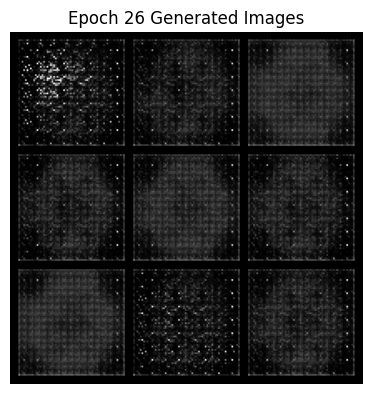

 27%|██▋       | 27/100 [26:00<1:11:35, 58.84s/it]

Epoch [27/100], Discriminator Loss: 0.6512, Generator Loss: 1.1454


 28%|██▊       | 28/100 [26:51<1:07:37, 56.35s/it]

Epoch [28/100], Discriminator Loss: 0.5334, Generator Loss: 1.5410


 29%|██▉       | 29/100 [27:41<1:04:27, 54.48s/it]

Epoch [29/100], Discriminator Loss: 0.3432, Generator Loss: 1.7764


 30%|███       | 30/100 [28:33<1:02:52, 53.90s/it]

Epoch [30/100], Discriminator Loss: 0.2650, Generator Loss: 2.4802


 31%|███       | 31/100 [29:29<1:02:33, 54.40s/it]

Epoch [31/100], Discriminator Loss: 0.2009, Generator Loss: 2.6624


 32%|███▏      | 32/100 [30:24<1:01:52, 54.60s/it]

Epoch [32/100], Discriminator Loss: 0.1503, Generator Loss: 2.5214


 33%|███▎      | 33/100 [31:19<1:01:05, 54.71s/it]

Epoch [33/100], Discriminator Loss: 0.7206, Generator Loss: 3.0334


 34%|███▍      | 34/100 [32:14<1:00:17, 54.81s/it]

Epoch [34/100], Discriminator Loss: 0.2181, Generator Loss: 2.2190


 35%|███▌      | 35/100 [33:09<59:28, 54.89s/it]  

Epoch [35/100], Discriminator Loss: 0.1385, Generator Loss: 3.1239


 36%|███▌      | 36/100 [34:04<58:40, 55.00s/it]

Epoch [36/100], Discriminator Loss: 0.2572, Generator Loss: 3.7051


 37%|███▋      | 37/100 [35:00<57:47, 55.04s/it]

Epoch [37/100], Discriminator Loss: 0.2120, Generator Loss: 3.8560


 38%|███▊      | 38/100 [35:55<56:59, 55.15s/it]

Epoch [38/100], Discriminator Loss: 0.0918, Generator Loss: 3.8605


 39%|███▉      | 39/100 [36:50<56:01, 55.10s/it]

Epoch [39/100], Discriminator Loss: 0.0892, Generator Loss: 4.3578


 40%|████      | 40/100 [37:45<55:00, 55.00s/it]

Epoch [40/100], Discriminator Loss: 0.0643, Generator Loss: 4.8140


 41%|████      | 41/100 [38:40<54:03, 54.97s/it]

Epoch [41/100], Discriminator Loss: 0.0463, Generator Loss: 5.1621


 42%|████▏     | 42/100 [39:35<53:09, 54.99s/it]

Epoch [42/100], Discriminator Loss: 0.0589, Generator Loss: 5.8252


 43%|████▎     | 43/100 [40:30<52:18, 55.06s/it]

Epoch [43/100], Discriminator Loss: 0.1401, Generator Loss: 5.4747


 44%|████▍     | 44/100 [41:25<51:27, 55.14s/it]

Epoch [44/100], Discriminator Loss: 1.0203, Generator Loss: 5.6822


 45%|████▌     | 45/100 [42:20<50:27, 55.04s/it]

Epoch [45/100], Discriminator Loss: 0.1738, Generator Loss: 2.7489


 46%|████▌     | 46/100 [43:15<49:32, 55.04s/it]

Epoch [46/100], Discriminator Loss: 0.2126, Generator Loss: 3.7090


 47%|████▋     | 47/100 [44:10<48:31, 54.94s/it]

Epoch [47/100], Discriminator Loss: 0.5934, Generator Loss: 1.9876


 48%|████▊     | 48/100 [45:05<47:36, 54.93s/it]

Epoch [48/100], Discriminator Loss: 0.2025, Generator Loss: 2.5361


 49%|████▉     | 49/100 [46:00<46:42, 54.94s/it]

Epoch [49/100], Discriminator Loss: 0.1941, Generator Loss: 2.5379


 50%|█████     | 50/100 [46:55<45:55, 55.11s/it]

Epoch [50/100], Discriminator Loss: 0.1514, Generator Loss: 2.8809


100%|██████████| 3/3 [00:55<00:00, 18.39s/it]

Epoch [51/100], Discriminator Loss: 0.1658, Generator Loss: 3.5561


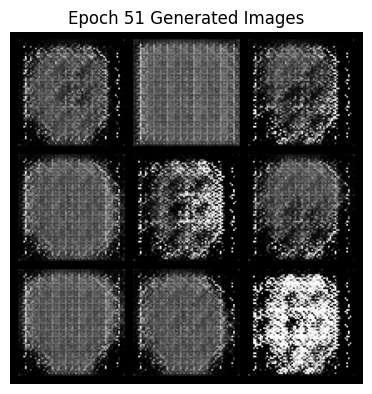

 52%|█████▏    | 52/100 [48:45<44:05, 55.11s/it]

Epoch [52/100], Discriminator Loss: 0.1580, Generator Loss: 4.5596


 53%|█████▎    | 53/100 [49:40<43:04, 55.00s/it]

Epoch [53/100], Discriminator Loss: 0.0575, Generator Loss: 4.5683


 54%|█████▍    | 54/100 [50:35<42:11, 55.02s/it]

Epoch [54/100], Discriminator Loss: 1.0565, Generator Loss: 5.1284


 55%|█████▌    | 55/100 [51:30<41:16, 55.04s/it]

Epoch [55/100], Discriminator Loss: 0.7243, Generator Loss: 3.4702


 56%|█████▌    | 56/100 [52:25<40:21, 55.02s/it]

Epoch [56/100], Discriminator Loss: 0.6588, Generator Loss: 4.4231


 57%|█████▋    | 57/100 [53:20<39:26, 55.04s/it]

Epoch [57/100], Discriminator Loss: 0.4115, Generator Loss: 4.0044


 58%|█████▊    | 58/100 [54:15<38:31, 55.04s/it]

Epoch [58/100], Discriminator Loss: 0.6882, Generator Loss: 4.7702


 59%|█████▉    | 59/100 [55:10<37:31, 54.91s/it]

Epoch [59/100], Discriminator Loss: 0.2455, Generator Loss: 2.9436


 60%|██████    | 60/100 [56:05<36:37, 54.94s/it]

Epoch [60/100], Discriminator Loss: 0.1999, Generator Loss: 3.2735


 61%|██████    | 61/100 [57:00<35:41, 54.92s/it]

Epoch [61/100], Discriminator Loss: 0.2770, Generator Loss: 4.1102


 62%|██████▏   | 62/100 [57:55<34:47, 54.94s/it]

Epoch [62/100], Discriminator Loss: 0.3942, Generator Loss: 4.5751


 63%|██████▎   | 63/100 [58:50<33:52, 54.95s/it]

Epoch [63/100], Discriminator Loss: 0.1847, Generator Loss: 3.8364


 64%|██████▍   | 64/100 [59:45<32:57, 54.94s/it]

Epoch [64/100], Discriminator Loss: 0.2431, Generator Loss: 5.5173


 65%|██████▌   | 65/100 [1:00:40<32:02, 54.92s/it]

Epoch [65/100], Discriminator Loss: 0.8442, Generator Loss: 5.1623


 66%|██████▌   | 66/100 [1:01:35<31:07, 54.93s/it]

Epoch [66/100], Discriminator Loss: 0.6412, Generator Loss: 4.2129


 67%|██████▋   | 67/100 [1:02:30<30:14, 54.99s/it]

Epoch [67/100], Discriminator Loss: 0.7982, Generator Loss: 2.8918


 68%|██████▊   | 68/100 [1:03:25<29:21, 55.05s/it]

Epoch [68/100], Discriminator Loss: 0.4809, Generator Loss: 2.2593


 69%|██████▉   | 69/100 [1:04:20<28:25, 55.02s/it]

Epoch [69/100], Discriminator Loss: 0.4941, Generator Loss: 3.6974


 70%|███████   | 70/100 [1:05:15<27:31, 55.03s/it]

Epoch [70/100], Discriminator Loss: 1.0216, Generator Loss: 3.4154


 71%|███████   | 71/100 [1:06:10<26:34, 54.99s/it]

Epoch [71/100], Discriminator Loss: 0.6858, Generator Loss: 3.5637


 72%|███████▏  | 72/100 [1:07:05<25:38, 54.96s/it]

Epoch [72/100], Discriminator Loss: 0.4136, Generator Loss: 2.9159


 73%|███████▎  | 73/100 [1:07:59<24:40, 54.85s/it]

Epoch [73/100], Discriminator Loss: 0.6528, Generator Loss: 4.7737


 74%|███████▍  | 74/100 [1:08:54<23:47, 54.89s/it]

Epoch [74/100], Discriminator Loss: 0.7581, Generator Loss: 3.1800


 75%|███████▌  | 75/100 [1:09:49<22:54, 54.98s/it]

Epoch [75/100], Discriminator Loss: 0.3612, Generator Loss: 3.3656


100%|██████████| 3/3 [00:55<00:00, 18.35s/it]

Epoch [76/100], Discriminator Loss: 0.5011, Generator Loss: 3.1110


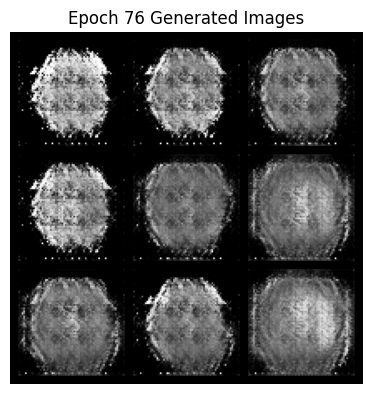

 77%|███████▋  | 77/100 [1:11:40<21:07, 55.11s/it]

Epoch [77/100], Discriminator Loss: 0.6736, Generator Loss: 3.7927


 78%|███████▊  | 78/100 [1:12:35<20:13, 55.15s/it]

Epoch [78/100], Discriminator Loss: 0.3159, Generator Loss: 3.4098


 79%|███████▉  | 79/100 [1:13:30<19:16, 55.06s/it]

Epoch [79/100], Discriminator Loss: 0.4946, Generator Loss: 3.9980


 80%|████████  | 80/100 [1:14:25<18:20, 55.05s/it]

Epoch [80/100], Discriminator Loss: 0.4328, Generator Loss: 4.0470


 81%|████████  | 81/100 [1:15:19<17:22, 54.87s/it]

Epoch [81/100], Discriminator Loss: 0.5149, Generator Loss: 4.2047


 82%|████████▏ | 82/100 [1:16:15<16:29, 54.98s/it]

Epoch [82/100], Discriminator Loss: 0.3036, Generator Loss: 3.6052


 83%|████████▎ | 83/100 [1:17:10<15:36, 55.10s/it]

Epoch [83/100], Discriminator Loss: 0.5432, Generator Loss: 3.8144


 84%|████████▍ | 84/100 [1:18:05<14:41, 55.09s/it]

Epoch [84/100], Discriminator Loss: 0.4297, Generator Loss: 4.0979


 85%|████████▌ | 85/100 [1:19:00<13:45, 55.03s/it]

Epoch [85/100], Discriminator Loss: 0.5468, Generator Loss: 5.7616


 86%|████████▌ | 86/100 [1:19:55<12:49, 54.94s/it]

Epoch [86/100], Discriminator Loss: 0.4350, Generator Loss: 5.0098


 87%|████████▋ | 87/100 [1:20:50<11:55, 55.05s/it]

Epoch [87/100], Discriminator Loss: 0.5129, Generator Loss: 5.1023


 88%|████████▊ | 88/100 [1:21:45<11:01, 55.12s/it]

Epoch [88/100], Discriminator Loss: 0.7105, Generator Loss: 4.0609


 89%|████████▉ | 89/100 [1:22:40<10:05, 55.09s/it]

Epoch [89/100], Discriminator Loss: 0.5291, Generator Loss: 3.1004


 90%|█████████ | 90/100 [1:23:35<09:10, 55.06s/it]

Epoch [90/100], Discriminator Loss: 0.5014, Generator Loss: 3.4549


 91%|█████████ | 91/100 [1:24:30<08:14, 54.96s/it]

Epoch [91/100], Discriminator Loss: 0.4002, Generator Loss: 3.5837


 92%|█████████▏| 92/100 [1:25:25<07:19, 54.94s/it]

Epoch [92/100], Discriminator Loss: 0.4368, Generator Loss: 3.1501


 93%|█████████▎| 93/100 [1:26:20<06:25, 55.04s/it]

Epoch [93/100], Discriminator Loss: 0.5714, Generator Loss: 4.3334


 94%|█████████▍| 94/100 [1:27:15<05:30, 55.08s/it]

Epoch [94/100], Discriminator Loss: 0.3358, Generator Loss: 3.9639


 95%|█████████▌| 95/100 [1:28:10<04:35, 55.07s/it]

Epoch [95/100], Discriminator Loss: 0.4728, Generator Loss: 4.5282


 96%|█████████▌| 96/100 [1:29:06<03:40, 55.10s/it]

Epoch [96/100], Discriminator Loss: 0.4327, Generator Loss: 3.9732


 97%|█████████▋| 97/100 [1:30:01<02:45, 55.16s/it]

Epoch [97/100], Discriminator Loss: 0.3665, Generator Loss: 3.3542


 98%|█████████▊| 98/100 [1:30:56<01:50, 55.06s/it]

Epoch [98/100], Discriminator Loss: 0.3715, Generator Loss: 4.0398


 99%|█████████▉| 99/100 [1:31:51<00:55, 55.04s/it]

Epoch [99/100], Discriminator Loss: 0.7775, Generator Loss: 4.7297


100%|██████████| 100/100 [1:32:46<00:00, 55.66s/it]

Epoch [100/100], Discriminator Loss: 0.5625, Generator Loss: 2.8979


In [ ]:
generator.train()
discriminator.train()

for epoch in tqdm(range(config['num_epochs']), position=0, leave=True):
    generator_running_loss = 0
    discriminator_running_loss = 0
    for idx, data in enumerate( tqdm(dataloader, position=0, leave=True)):
        img = data[0].to(config['device'])
        dummy_labels = data[1]
        
        label_real_image = torch.full((dummy_labels.size()), 1, dtype=torch.float)
        label_fake_image = torch.full((dummy_labels.size()), 0, dtype=torch.float)
        noise = torch.randn(dummy_labels.size()[0], config['input_noise_dim'], 1, 1, device=config['device'])
        
        ## Train Discriminator with real images
        d_predict_real = discriminator(img).view(-1)
        d_loss_real = criterion(d_predict_real, label_real_image) # d predict real close to 1
        discriminator.zero_grad()
        d_loss_real.backward()
        
        ## Train Discriminator with fake images
        generator_fake_img = generator(noise)
        d_predict_fake = discriminator(generator_fake_img.detach()).view(-1)
        d_loss_fake = criterion(d_predict_fake, label_fake_image) # d predict fake close to 0
        d_loss_fake.backward()
        
        discriminator_running_loss += d_loss_real.item() + d_loss_fake.item()
        discriminator_optimizer.step()
        
        ## Train Generator
        d_predict_fake = discriminator(generator_fake_img).view(-1) 
        g_loss = criterion(d_predict_fake, label_real_image) # try to fool the discriminator
        generator_running_loss += g_loss.item()
        generator.zero_grad()
        g_loss.backward()
        generator_optimizer.step()
    
    discriminator_loss = discriminator_running_loss / 2 / (idx + 1) # average loss per batch
    generator_loss = generator_running_loss / (idx + 1)
    
    print(f"Epoch [{epoch+1}/{config['num_epochs']}], Discriminator Loss: {discriminator_loss:.4f}, Generator Loss: {generator_loss:.4f}")
    
    if epoch % 25 == 0: # every 25 epochs
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.axis("off")
        plt.title(f"Epoch {epoch+1} Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(generator_fake_img[:9], padding=5, normalize=True, nrow=3).cpu(),(1,2,0)))
        plt.show()